In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.manifold import TSNE
from dom_mis import generate_graph_from_similarity_matrix
import colorcet as cc
from ela_feature_definition import ela_feature_names
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
def plot_dom_mis_distribution_in_clusters(cluster_df, cluster_label_column):
    print(cluster_label_column)
    cluster_only=cluster_df[cluster_label_column]
    for algorithm in ['dominant','mis']:
        all_cluster_distributions=defaultdict(lambda: pd.DataFrame())
        for similarity_threshold in [0.9,0.95,0.97]:
            for run_id in range(0,30):
                ds_results=pd.read_csv(f'results/dropna/{algorithm}/{similarity_threshold}_{run_id}.csv',index_col=[0])

                ds_results=ds_results.merge(cluster_only, left_on=['suite','fid','iid'], right_index=True)
                ds_cluster_distribution=ds_results.groupby(cluster_label_column).count()['suite'].T
                all_cluster_distributions[f'{similarity_threshold}_{run_id}']=ds_cluster_distribution

        all_cluster_distributions_df=pd.DataFrame(all_cluster_distributions).fillna(0)

        fig, ax = plt.subplots(figsize=(20,5),sharey=True)
        ax.set_title(cluster_label_column)
        sns.heatmap(all_cluster_distributions_df,cmap=sns.color_palette("Paired", 8),ax=ax)
    

In [3]:
cluster_df_10 = pd.read_csv('data/data_clustered.txt',index_col=[0],sep='\t')
cluster_df_10=cluster_df_10.set_index(["suite","fid","iid"])
cluster_label_column_10='label'

In [4]:
pd.read_csv('data/data_clustered.txt',index_col=[0],sep='\t')['suite'].drop_duplicates()

1         bbob
121    cec2013
148    cec2014
178    cec2015
193    cec2017
Name: suite, dtype: object

In [5]:
cluster_df_12 = pd.read_csv('data/hierarchical_clustering_12.csv',index_col=[0,1,2])
cluster_label_column_12='clustering_12_clusters'

In [6]:
cluster_df_59 = pd.read_csv('data/hierarchical_clustering_59.csv',index_col=[0,1,2])
cluster_label_column_59='clustering_59_clusters'

In [7]:
cluster_df_sub_all = pd.read_csv('data/subclustering.csv',index_col=[0,1,2])
selected_cluster_counts = [10,15,21,34,46,48]

In [8]:
cluster_df_r = pd.read_csv('data/label_data.txt',index_col=[0],sep='\t')
cluster_df_r = cluster_df_r.set_index(['suite','fid','iid'],drop=True)
cluster_label_column_r='labels'

In [9]:

def plot_clusters(cluster_config, save=False):
    ela = pd.read_csv('data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
    ela_2d=TSNE(n_components=2, metric='cosine').fit_transform(ela)
    ela_2d=pd.DataFrame(ela_2d, index=ela.index, columns=['x','y'])
    for cluster_config_name, cluster_config_values in cluster_config.items():
        
        
        df = cluster_config_values['data'].copy()
        ela_2d[cluster_config_name]= df[cluster_config_values['label_column']]
        ela_2d.plot.scatter(x='x',y='y',c=cluster_config_name,colormap="tab20c",legend=True,xlabel=None,ylabel=None)
        
        if save:
            
            plt.savefig(f'cluster_visualizations/{cluster_config_name}.pdf')
        

In [10]:

def save_clusters_for_overleaf(cluster_config):
    ela = pd.read_csv('data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
    ela_2d=TSNE(n_components=2, metric='cosine').fit_transform(ela)
    ela_2d=pd.DataFrame(ela_2d, index=ela.index, columns=['x','y'])
    for cluster_config_name, cluster_config_values in cluster_config.items():
        
        
        df = cluster_config_values['data'].copy()
        df_to_plot=ela_2d.copy()
        df_to_plot[' ']= df[cluster_config_values['label_column']].copy()
        ax=df_to_plot.plot.scatter(x='x',y='y',c=' ',colormap="tab20c",legend=True,xlabel=None,ylabel=None)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig(f'cluster_visualizations/{cluster_config_name}.pdf')
        

In [11]:
cluster_config={'cluster_10': {'data': cluster_df_10, 'label_column': cluster_label_column_10},
                'cluster_r': {'data': cluster_df_r, 'label_column': cluster_label_column_r},
               'cluster_12': {'data': cluster_df_12, 'label_column': cluster_label_column_12},
               'cluster_59': {'data': cluster_df_59, 'label_column': cluster_label_column_59},
               }
selected_cluster_counts = [10,15,21,34,46,48]
for selected_cluster_count in selected_cluster_counts:
    cluster_label_column_sub=f'subclustering_{selected_cluster_count}_clusters'
    cluster_df_sub=cluster_df_sub_all[[cluster_label_column_sub]+ela_feature_names]
    cluster_config[f'cluster_sub_{selected_cluster_count}']={'data': cluster_df_sub, 'label_column': cluster_label_column_sub}

In [12]:
def analyze_single_clusters(cluster_df, cluster_label_column):
    cluster_sizes=pd.DataFrame(cluster_df[cluster_label_column].values).value_counts()
    single_clusters=[x[0] for x in cluster_sizes[cluster_sizes==1].index]
    single_cluster_indices = cluster_df[cluster_df[cluster_label_column].isin(single_clusters)].index
    
    
    
    for similarity_threshold in [0.9]:
        G = generate_graph_from_similarity_matrix(similarity_threshold)
        single_nodes = list(filter (lambda x: x[1]==0, G.degree))
        single_nodes=[x[0] for x in single_nodes]
        #sorted_nodes=sorted(G.degree, key=lambda x: x[1])[0:20]
        print(f'Single cluster indices: {len(single_cluster_indices)}')
        print(f'Similarity threshold: {similarity_threshold}')
        print(f'Single nodes: {len(single_nodes)}')
        print(f'Intersection: {len(set(single_cluster_indices).intersection(set(single_nodes)))}')
        print(f'Single clusters - single nodes : {len(set(single_cluster_indices).difference(set(single_nodes)))}')
        print(f'Single nodes - single clusters : {len(set(single_nodes).difference(set(single_cluster_indices)))}')
        print()
    

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


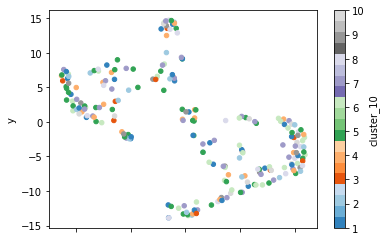

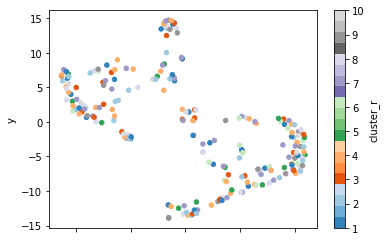

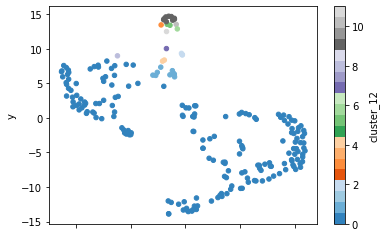

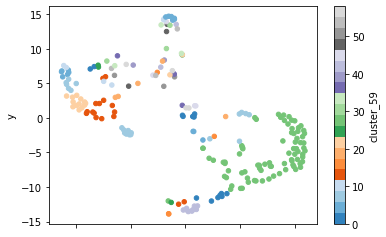

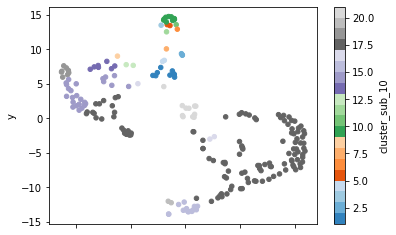

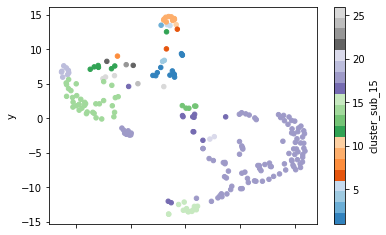

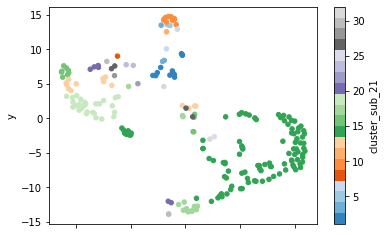

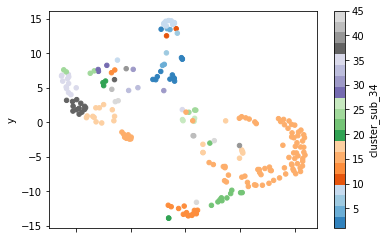

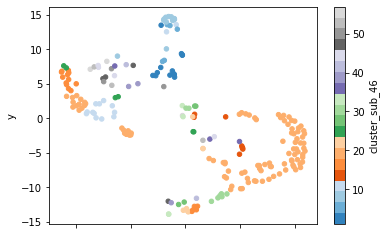

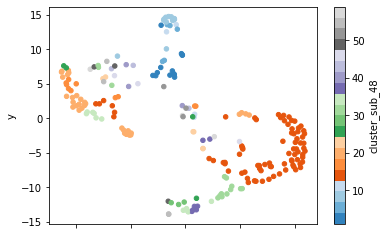

In [13]:
plot_clusters(cluster_config)

cluster_10
label
cluster_r
labels
cluster_12
clustering_12_clusters
cluster_59
clustering_59_clusters
cluster_sub_10
subclustering_10_clusters
cluster_sub_15
subclustering_15_clusters
cluster_sub_21
subclustering_21_clusters
cluster_sub_34
subclustering_34_clusters
cluster_sub_46
subclustering_46_clusters
cluster_sub_48
subclustering_48_clusters


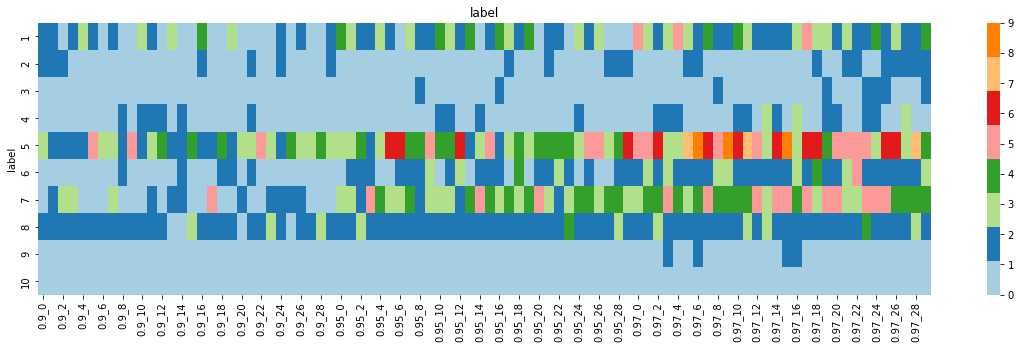

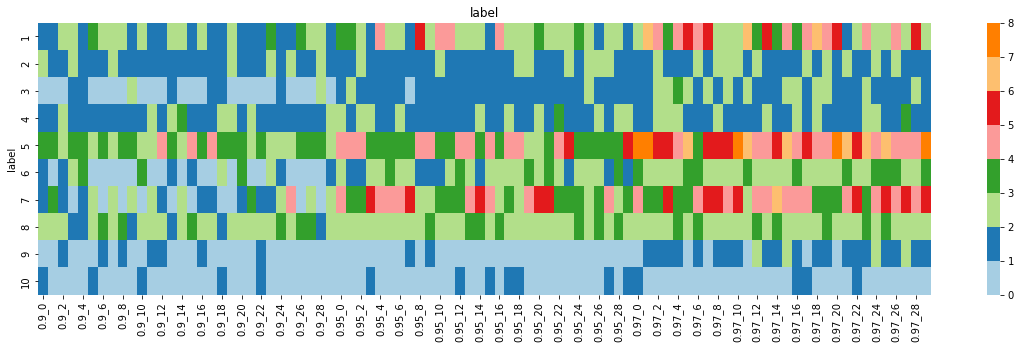

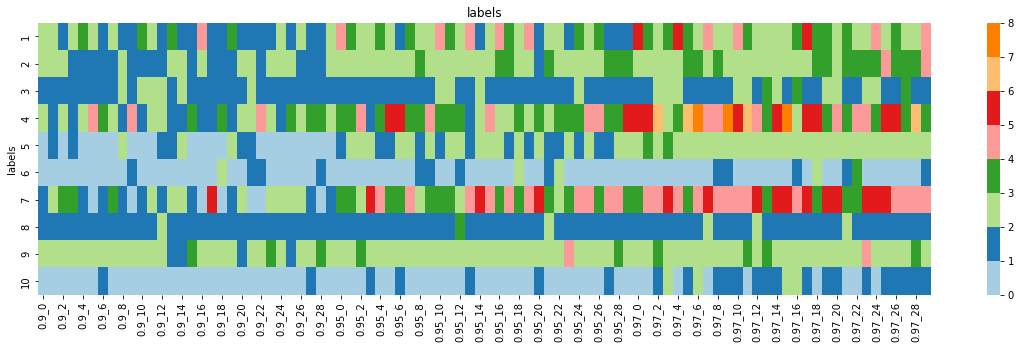

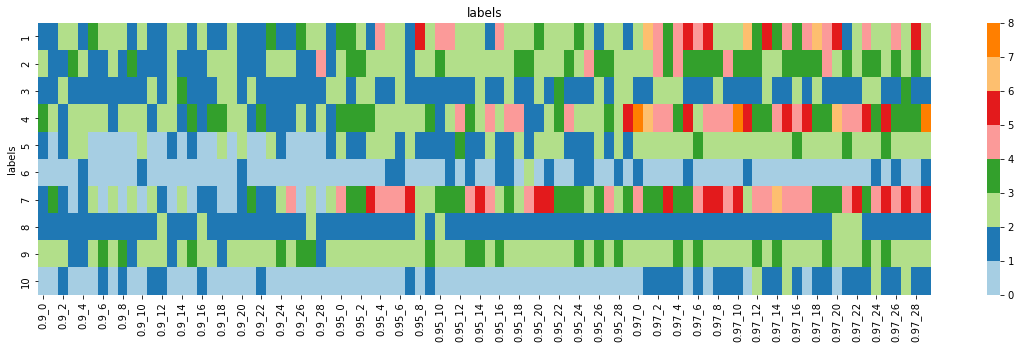

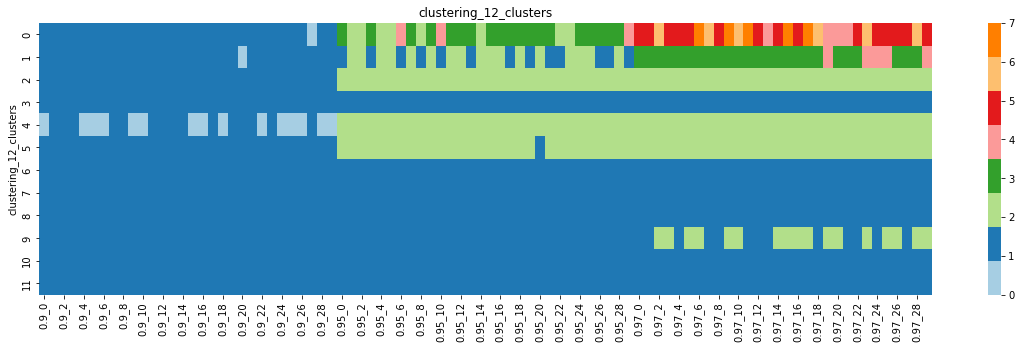

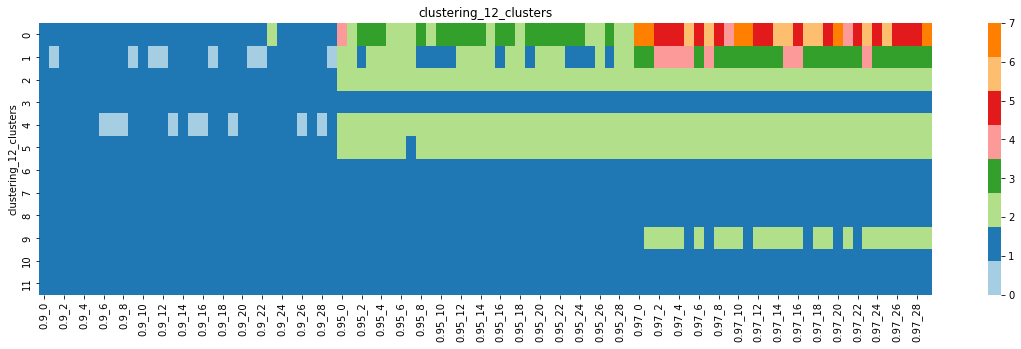

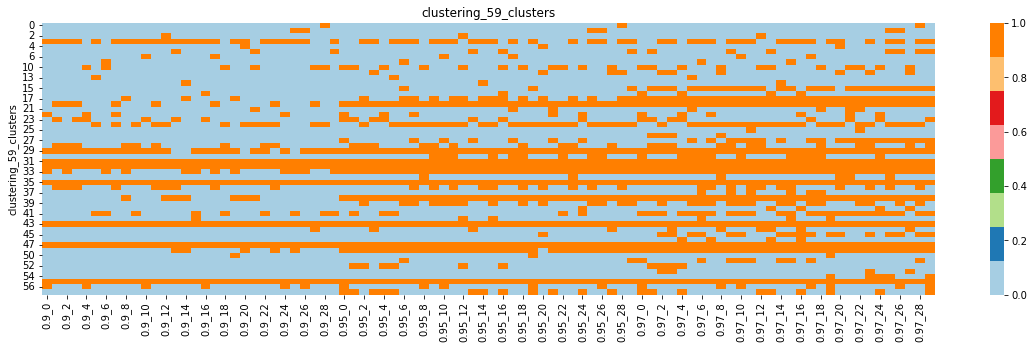

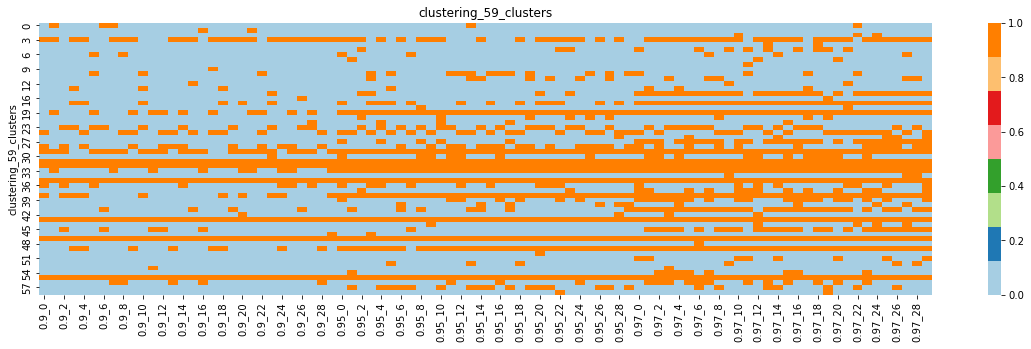

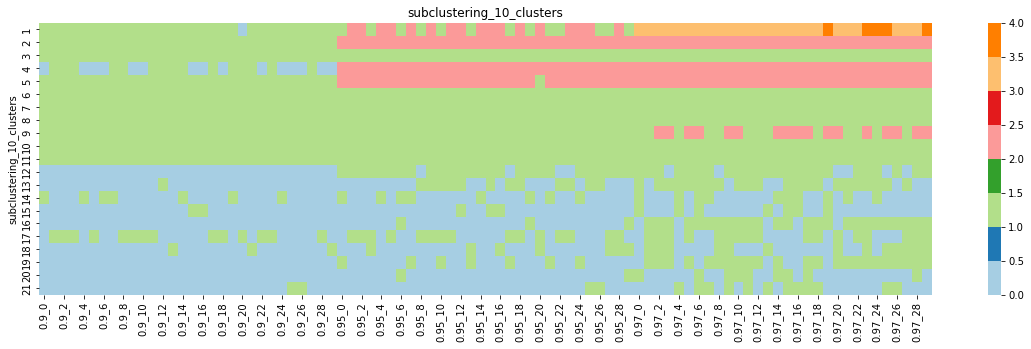

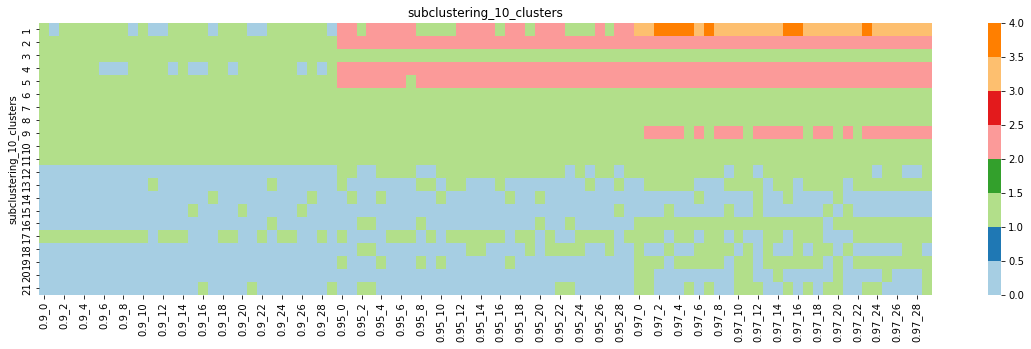

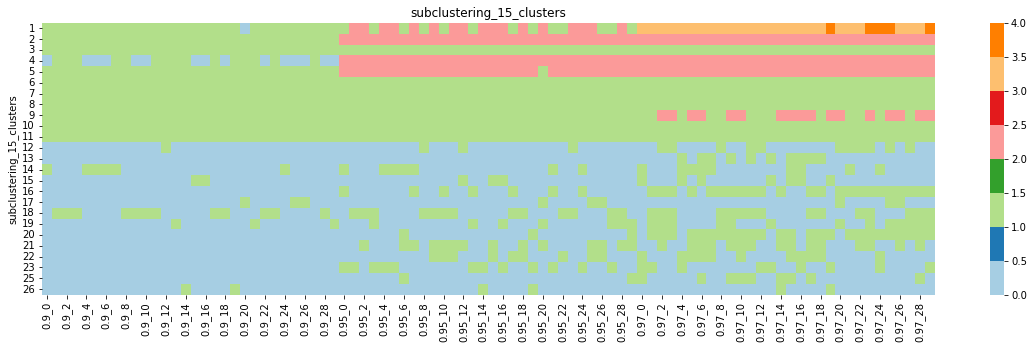

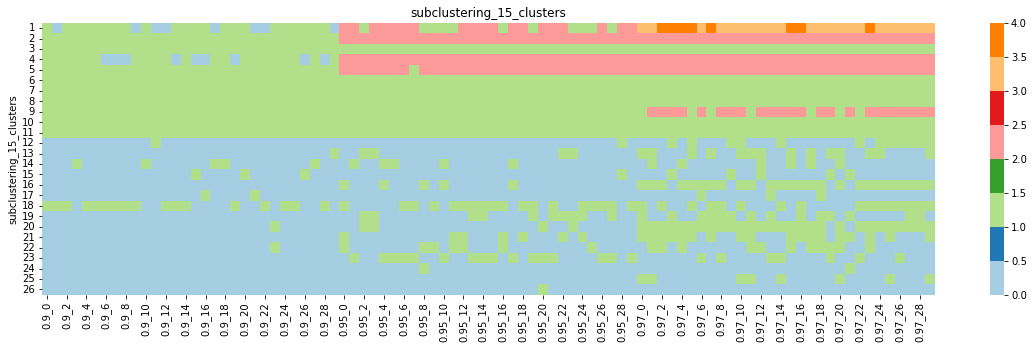

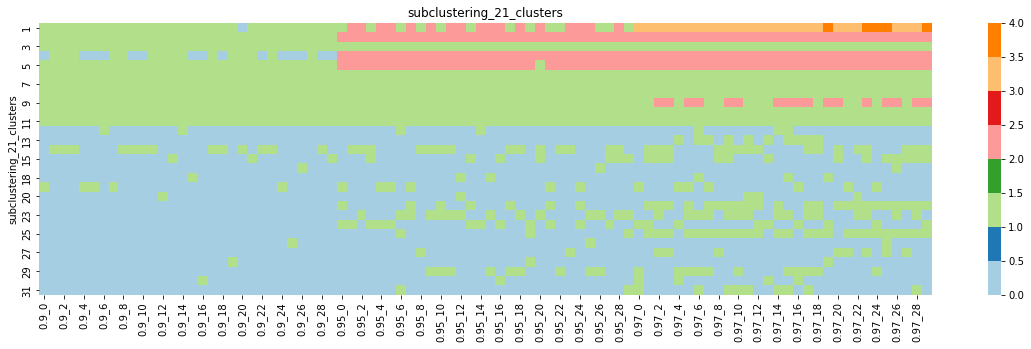

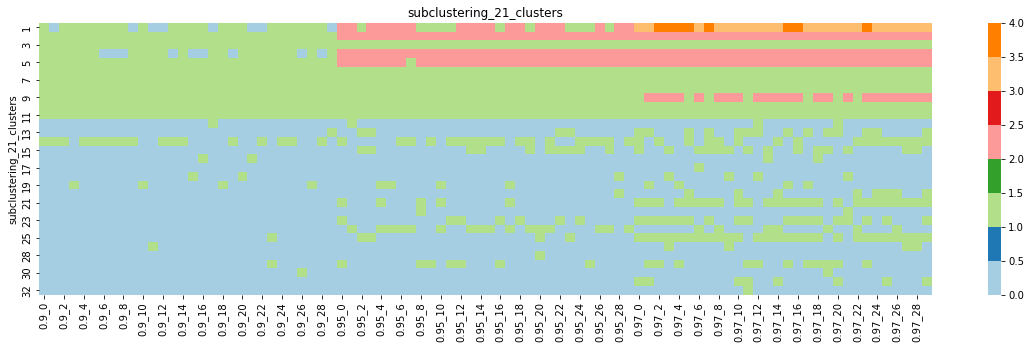

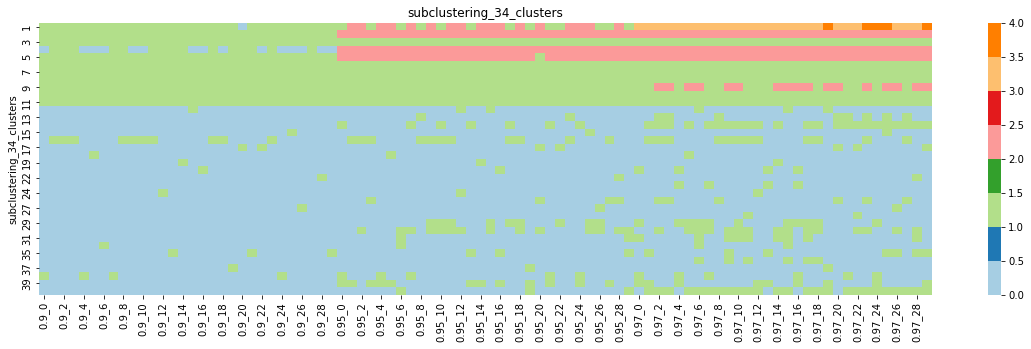

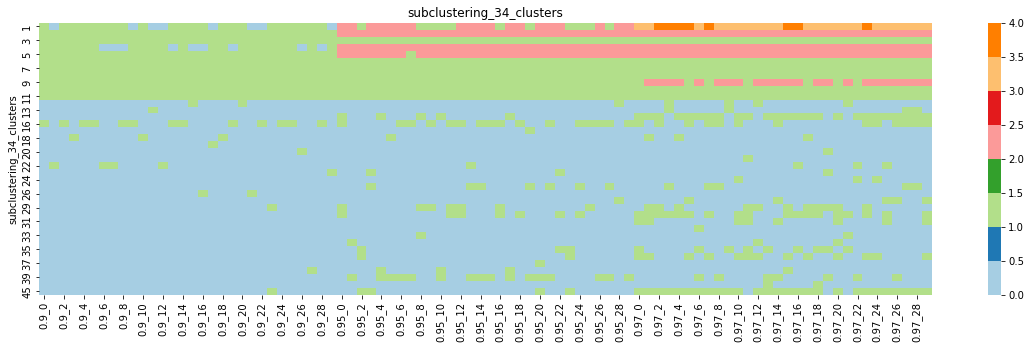

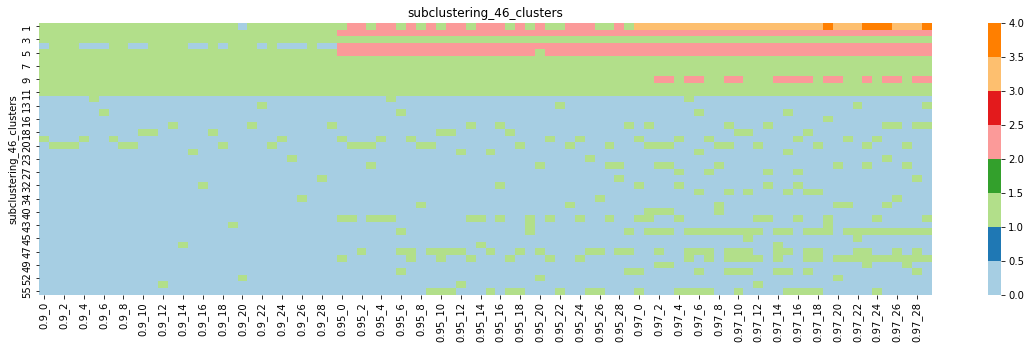

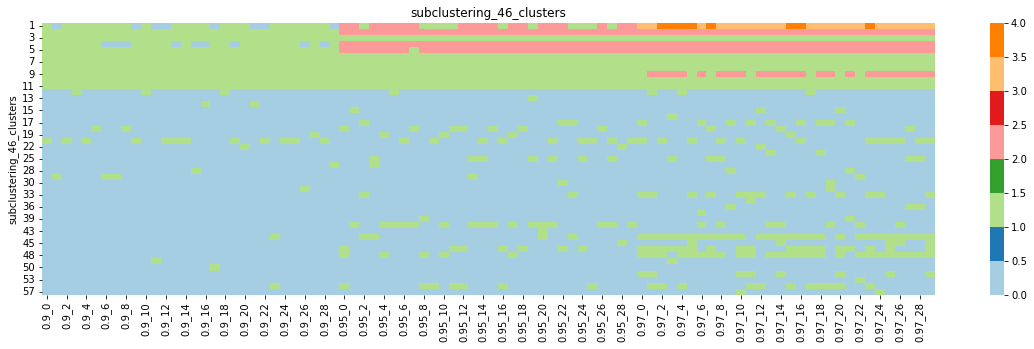

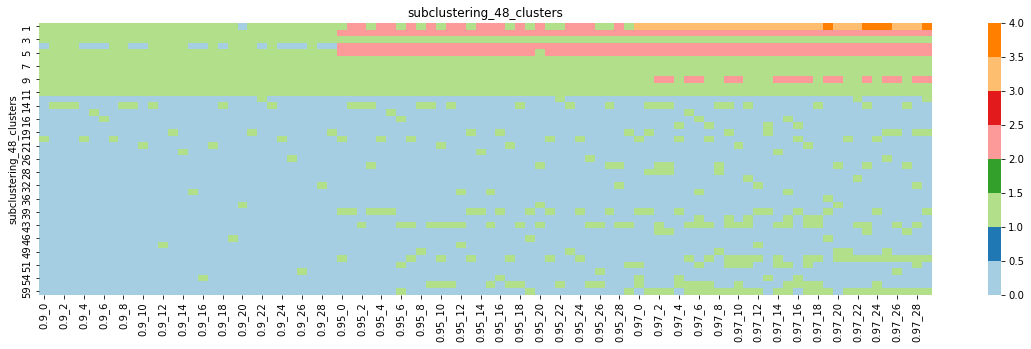

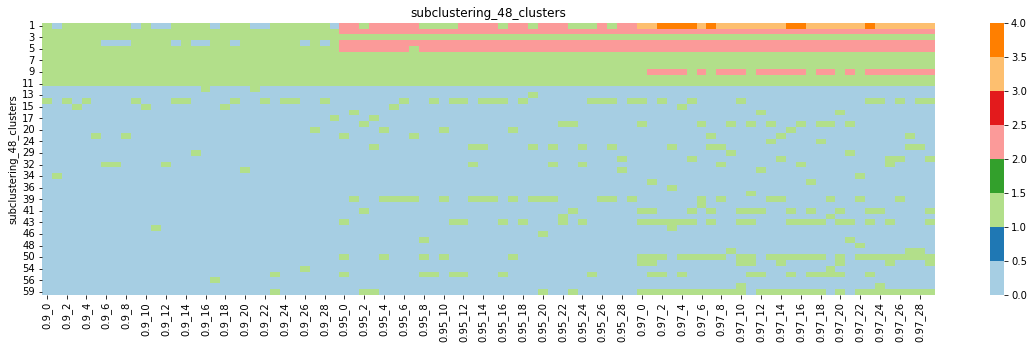

In [14]:
for cluster_config_name, cluster_config_values in cluster_config.items():
    print(cluster_config_name)
    plot_dom_mis_distribution_in_clusters(cluster_config_values['data'], cluster_config_values['label_column'])

In [15]:
for cluster_config_name, cluster_config_values in cluster_config.items():
    print(cluster_config_name)
    analyze_single_clusters(cluster_config_values['data'], cluster_config_values['label_column'])

cluster_10
Single cluster indices: 0
Similarity threshold: 0.9
Single nodes: 6
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 6

cluster_r
Single cluster indices: 0
Similarity threshold: 0.9
Single nodes: 6
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 6

cluster_12
Single cluster indices: 6
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 0
Single nodes - single clusters : 0

cluster_59
Single cluster indices: 37
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 31
Single nodes - single clusters : 0

cluster_sub_10
Single cluster indices: 7
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 1
Single nodes - single clusters : 0

cluster_sub_15
Single cluster indices: 11
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 5
Single nodes - single clusters

In [16]:
df=cluster_df_12.copy()
centroids=[]
for cluster_no in range(0,12):
    cluster_samples = cluster_df_12[cluster_df_12[cluster_label_column_12]==cluster_no]
    ds = cosine_similarity(cluster_samples[ela_feature_names].values, cluster_samples[ela_feature_names].values)
    ds = pd.DataFrame(ds, index=cluster_samples.index, columns=cluster_samples.index)
    mean_distances=ds.mean()
    min_distance=mean_distances.min()
    print(min_distance)
    print(mean_distances[mean_distances==min_distance])
    centroids.append(mean_distances[mean_distances==min_distance].index[0])

0.9249462303349419
suite  fid  iid
bbob   17   1      0.924946
dtype: float64
0.9709432022957394
suite  fid  iid
bbob   17   4      0.970943
dtype: float64
0.9535756053393231
suite  fid  iid
bbob   23   2      0.953576
dtype: float64
1.0000000000000004
suite  fid  iid
bbob   23   5      1.0
dtype: float64
0.9791759619306557
suite  fid  iid
bbob   17   2      0.979176
       22   3      0.979176
dtype: float64
0.9878732952889628
suite  fid  iid
bbob   1    3      0.987873
dtype: float64
1.0
suite  fid  iid
bbob   18   5      1.0
dtype: float64
1.0
suite  fid  iid
bbob   19   4      1.0
dtype: float64
0.9999999999999998
suite  fid  iid
bbob   14   2      1.0
dtype: float64
0.9792521275962007
suite  fid  iid
bbob   23   3      0.979252
dtype: float64
0.9999999999999999
suite  fid  iid
bbob   17   5      1.0
dtype: float64
0.9999999999999997
suite  fid  iid
bbob   1    4      1.0
dtype: float64


In [136]:
marker_dict = {'bbob': 'P', 'cec2013':'o', 'cec2014': 'v', 'cec2015':'s', 'cec2017':'*'}
colors = ['#000000,',
          '#e41a1c',
'#377eb8',
'#4daf4a',
'#984ea3',
'#ff7f00',
'#ffff33',
'#a65628',
'#f781bf',
'#999999',
          '#000d9e',
          '#619e00'
         ]
def save_clusters_for_overleaf(cluster_config):
    ela = pd.read_csv('data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
    ela_2d=TSNE(n_components=2, metric='cosine').fit_transform(ela)
    ela_2d=pd.DataFrame(ela_2d, index=ela.index, columns=['x','y'])
    min_x, min_y, max_x, max_y=ela_2d['x'].min(), ela_2d['y'].min(), ela_2d['x'].max(), ela_2d['y'].max()
    for cluster_config_name, cluster_config_values in cluster_config.items():
        df = cluster_config_values['data'].copy()
        df_to_plot=ela_2d.copy()
        
        df_to_plot['cluster']= df[cluster_config_values['label_column']].copy()
        df_to_plot=df_to_plot.sort_values('cluster')
        print(df_to_plot['cluster'].drop_duplicates())
        df_to_plot=df_to_plot.reset_index().dropna()
        plt.figure(figsize=(7,5))
        ax = plt.subplot(111)
        df_to_plot['marker']=df_to_plot.suite.apply(lambda x: marker_dict[x])
        cluster_number=df_to_plot['cluster'].drop_duplicates().shape[0]
        seaborn_plot=sns.scatterplot(data=df_to_plot,x='x',y='y',hue='cluster', 
                                     palette=sns.color_palette(cc.glasbey, n_colors=cluster_number),
                                     style=df_to_plot['suite'], 
                                     legend='brief',ax=ax)
        #plt.legend( ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
        handles, labels = ax.get_legend_handles_labels()
        index_of_suite=labels.index('suite')

            
        labels = [l if l!='suite' else 'benchmark suite' for l in labels]

        ax.legend(handles, labels,ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))

        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.xlim([min_x-1,max_x+1])
        plt.ylim([min_y-1,max_y+1])
        #plt.show()
        #plt.tight_layout()
        plt.savefig(f'cluster_visualizations/{cluster_config_name}_per_suite.pdf', bbox_inches='tight')
        

suite    fid  iid
bbob     17   1      12
         14   1      12
         4    5      13
              4      13
              2      13
                     ..
cec2013  16   1      21
cec2015  7    1      21
bbob     16   3      21
cec2014  19   1      21
bbob     16   1      21
Name: subclustering_10_clusters, Length: 190, dtype: int64


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


suite    fid  iid
cec2017  30   1       0
bbob     1    1       1
         16   5       2
         23   5       3
         22   3       4
         1    3       5
         18   5       6
         19   4       7
         14   2       8
         22   1       9
         17   5      10
         1    4      11
Name: cluster, dtype: int64
suite    fid  iid
bbob     17   1       12
         14   5       13
         8    4       14
cec2013  18   1       15
cec2014  28   1       16
         23   1       17
bbob     2    1       18
cec2013  11   1       19
bbob     1    5       20
         5    1       21
         1    1      NaN
Name: cluster, dtype: object


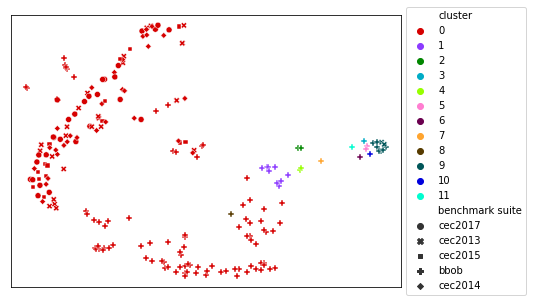

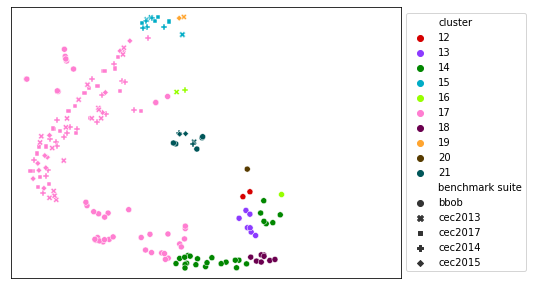

In [137]:
final_cluster_config={}
final_cluster_config['Initial 12 clusters']= cluster_config['cluster_12'].copy()
final_cluster_config['Final 21 clusters']= cluster_config['cluster_sub_10'].copy()

clusters_21_label=cluster_config['cluster_sub_10']['label_column']
clusters_21_data=cluster_config['cluster_sub_10']['data'].copy().sort_values(clusters_21_label)

#clusters_1_12_data = clusters_21_data[clusters_21_data[clusters_21_label]=='1-11']
#clusters_1_12_data[clusters_21_label]='1-11'

clusters_12_15_data = clusters_21_data[clusters_21_data[clusters_21_label]>11].sort_values(clusters_21_label)
print(clusters_12_15_data[clusters_21_label])
clusters_12_15_data[clusters_21_label]=clusters_12_15_data[clusters_21_label].apply(lambda x: str(x))
#clusters_data = clusters_1_12_data.append(clusters_12_15_data)
final_cluster_config['Final 21 clusters']['data']= clusters_12_15_data #clusters_data

save_clusters_for_overleaf(final_cluster_config)

In [111]:
clusters_21_data=cluster_config['cluster_sub_10']['data'].copy()
clusters_21_label=cluster_config['cluster_sub_10']['label_column']

In [115]:
clusters_21_data[clusters_21_data[clusters_21_label]==17].shape

(119, 64)

In [ ]:
for cluster_name in ['cluster_12','cluster_sub_10','cluster_sub_15']:
    cluster_df = cluster_config[cluster_name]['data']
    cluster_label = cluster_config[cluster_name]['label_column']
    cluster_sizes=pd.DataFrame(cluster_df[cluster_label].values).value_counts().sort_index()
    cluster_sizes.to_latex(f'cluster_visualizations/{cluster_name}.tex')

In [39]:
final_clusters=cluster_config['cluster_sub_10']['data'].copy()
final_clusters_label_column=cluster_config['cluster_sub_10']['label_column']
final_clusters=final_clusters[final_clusters_label_column]
final_clusters=final_clusters.reset_index()

In [45]:
final_clusters

,suite,fid,iid,cluster
0,bbob,1,2,17
1,bbob,1,5,20
2,bbob,2,1,18
3,bbob,2,2,18
4,bbob,2,3,18
...,...,...,...,...
216,bbob,23,3,9
217,bbob,23,4,9
218,bbob,23,5,3
219,cec2013,8,1,9


In [106]:
final_21_clusters = pd.read_csv('data/subclustering.csv',index_col=[0,1,2]).rename(columns={'subclustering_10_clusters':'cluster'})['cluster']

final_21_clusters=final_21_clusters.reset_index()

In [107]:
final_21_clusters

,suite,fid,iid,cluster
0,bbob,1,2,17
1,bbob,1,5,20
2,bbob,2,1,18
3,bbob,2,2,18
4,bbob,2,3,18
...,...,...,...,...
216,bbob,23,3,9
217,bbob,23,4,9
218,bbob,23,5,3
219,cec2013,8,1,9


In [108]:
from collections import defaultdict
cluster_suite=defaultdict(lambda: {})
for suite in final_21_clusters['suite'].drop_duplicates().values:
    for cluster in final_21_clusters['cluster'].drop_duplicates().values:
        cluster_suite[cluster][suite]=final_21_clusters[(final_21_clusters['suite']==suite)&(final_21_clusters['cluster']==cluster)].shape[0]
cluster_suite_df=pd.DataFrame(cluster_suite).T
cluster_suite_df['total']=cluster_suite_df.sum(axis=1)

In [109]:
cluster_suite_df=cluster_suite_df.sort_index()
cluster_suite_df.columns=[c.upper() for c in cluster_suite_df.columns]

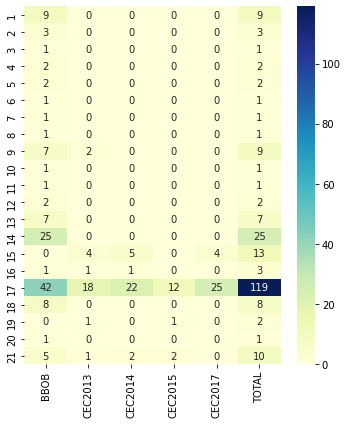

In [144]:
plt.figure(figsize=(5,6))
sns.heatmap(cluster_suite_df, cmap="YlGnBu", annot=True, fmt="d")
plt.tight_layout()
plt.savefig('cluster_visualizations/benchmarks_per_cluster_counts.pdf',pad_inches=0,bbox_inches=0)